In [1]:
import time
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
import pandas as pd
import seaborn as sns
import math
import sys
import os
from sabreMod import sosf,sosfh
from scipy import interpolate

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="20"

In [2]:
start=time.time()

In [3]:
orion=pd.read_table('Obs/Orion.csv', delimiter=',')
orion.describe()

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-0.133333,0.300000,0.366667,0.095833,0.525000,0.062500,-0.700000,-0.295833,0.141667,-0.279167,...,-1.654167,-2.845833,-1.891667,-1.308333,-0.825000,-1.041667,-0.633333,-0.166667,0.229167,0.450000
std,0.814898,1.298494,0.995497,1.257492,1.217713,1.553905,2.062291,3.833092,2.790343,2.699272,...,3.067640,2.998692,2.519647,2.137230,2.639376,1.916500,1.313034,0.755079,0.859464,1.595919
min,-3.900000,-2.500000,0.000000,-3.500000,-1.000000,-2.900000,-4.500000,-7.000000,-3.100000,-3.900000,...,-7.400000,-9.100000,-6.400000,-6.000000,-6.100000,-5.100000,-4.600000,-3.700000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,-2.325000,-2.550000,-2.325000,-2.100000,...,-3.150000,-5.000000,-4.725000,-2.625000,-2.200000,-1.925000,-0.175000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.400000,-0.300000,-0.050000,...,-1.900000,-2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.200000,0.925000,0.000000,0.000000,0.125000,1.000000,0.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.700000,4.300000,4.600000,3.200000,3.900000,5.100000,3.800000,10.400000,6.900000,8.900000,...,6.800000,1.900000,1.400000,3.100000,7.400000,1.400000,0.500000,0.000000,4.000000,7.000000


orion[orion == 0] = 'nan' 
orion

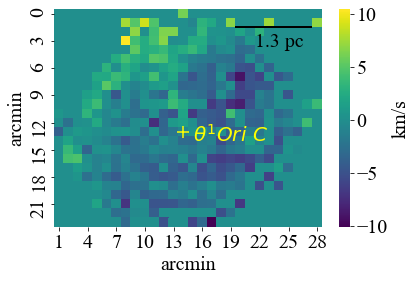

In [4]:
fig, ax = plt.subplots()
sns.heatmap(orion,cmap="viridis",cbar_kws={'label': 'km/s'})
plt.scatter(13.5, 13.5, marker='+', color='yellow', s=150)
ax.set(xlabel='arcmin', ylabel='arcmin')

ax.text(0.93, 0.81, '1.3 pc',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=20)
    
plt.axhline(y=2, xmin=0.68, xmax=0.96, linewidth=2, color = 'k')

plt.text(14.5, 14.5, '$θ^{1}Ori\ C$', fontsize=20, color='yellow')

plt.show()

In [5]:
df=orion.stack().reset_index().rename(columns={'level_0':'RAdeg', 'level_1':'DEdeg', 0:'RVHalpha'})
df.describe()

,RAdeg,RVHalpha
count,672.000000,672.000000
mean,11.500000,-0.667857
std,6.927343,2.440544
min,0.000000,-10.100000
25%,5.750000,-2.000000
50%,11.500000,0.000000
75%,17.250000,0.000000
max,23.000000,10.400000


In [6]:
df.RAdeg=1.0*df.RAdeg

In [7]:
df.DEdeg=pd.to_numeric(df.DEdeg)*1.0

Structure Function

In [8]:
df0 = pd.DataFrame({'X': df.RAdeg, 'Y': df.DEdeg, 'RV': df.RVHalpha})
df0.describe()

,X,Y,RV
count,672.000000,672.000000,672.000000
mean,11.500000,14.500000,-0.667857
std,6.927343,8.083764,2.440544
min,0.000000,1.000000,-10.100000
25%,5.750000,7.750000,-2.000000
50%,11.500000,14.500000,0.000000
75%,17.250000,21.250000,0.000000
max,23.000000,28.000000,10.400000


In [9]:
df0["RV"] = df0["RV"].replace(['0', 0], np.nan)

In [10]:
df0.describe()

,X,Y,RV
count,672.000000,672.000000,359.000000
mean,11.500000,14.500000,-1.250139
std,6.927343,8.083764,3.230147
min,0.000000,1.000000,-10.100000
25%,5.750000,7.750000,-3.400000
50%,11.500000,14.500000,-1.800000
75%,17.250000,21.250000,0.700000
max,23.000000,28.000000,10.400000


In [11]:
data=df0

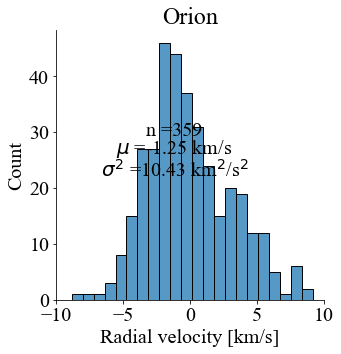

In [12]:
#fig, ax = plt.subplots()

sns.displot(data.RV-data.RV.mean(),bins=25)
plt.xlim(-10,10)

plt.text(0.45, 0.86,'n ='+str(data.RV.count()), ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.45, 0.78,'$μ$ ='+str(np.round(data.RV.mean(),2))+' km/s', ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.45, 0.68,'$σ^{2}$ ='+str(np.round(data.RV.var(),2))+' km$^{2}$/s$^{2}$', ha='center', va='center', transform=ax.transAxes, color='k')

plt.title('Orion')

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

plt.xlabel('Radial velocity [km/s]')
plt.savefig('Hist//Orion.pdf', bbox_inches='tight')

Dr. Will

In [13]:
df1 = pd.DataFrame({'RA': df.RAdeg, 'DE': df.DEdeg, 'V': df.RVHalpha, '_key': 1})
df1.describe()

,RA,DE,V,_key
count,672.000000,672.000000,672.000000,672.0
mean,11.500000,14.500000,-0.667857,1.0
std,6.927343,8.083764,2.440544,0.0
min,0.000000,1.000000,-10.100000,1.0
25%,5.750000,7.750000,-2.000000,1.0
50%,11.500000,14.500000,0.000000,1.0
75%,17.250000,21.250000,0.000000,1.0
max,23.000000,28.000000,10.400000,1.0


In [14]:
df2 = df1.copy()

In [15]:
pairs = pd.merge(df1, df2, on='_key', suffixes=('', '_')).drop('_key', 1)
pairs.index = pd.MultiIndex.from_product((df1.index, df2.index))

pairs.head()

RA   DE    V  RA_  DE_   V_
0 0  0.0  1.0  0.0  0.0  1.0  0.0
  1  0.0  1.0  0.0  0.0  2.0  0.0
  2  0.0  1.0  0.0  0.0  3.0  0.0
  3  0.0  1.0  0.0  0.0  4.0  0.0
  4  0.0  1.0  0.0  0.0  5.0  0.0

In [16]:
pairs.loc[:, 'dDE'] =(pairs.DE - pairs.DE_)
pairs.loc[:, 'dRA'] =(pairs.RA - pairs.RA_)*np.cos(np.radians(0.5*(pairs.DE + pairs.DE_)))
#pairs.loc[:, 's'] = np.log10(np.hypot(pairs.dRA, pairs.dDE))
pairs.loc[:, 's'] = np.hypot(pairs.dRA, pairs.dDE)
pairs.loc[:, 'log_s'] = np.log10(pairs.s)
pairs.loc[:, 'dV'] = pairs.V - pairs.V_
pairs.loc[:, 'dV2'] = pairs.dV**2
pairs.loc[:, 'log_dV2'] = np.log10(pairs.dV**2)
pairs.loc[:, 'VV_mean'] = 0.5*(pairs.V + pairs.V_)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
pairs = pairs[(pairs.dDE > 0.0) & (pairs.dRA > 0.0)]
pairs.head()

RA   DE    V  RA_  DE_   V_  dDE       dRA         s     log_s   dV  \
29 0  1.0  2.0  0.0  0.0  1.0  0.0  1.0  0.999657  1.413971  0.150441  0.0   
30 0  1.0  3.0  0.0  0.0  1.0  0.0  2.0  0.999391  2.235796  0.349432  0.0   
   1  1.0  3.0  0.0  0.0  2.0  0.0  1.0  0.999048  1.413541  0.150308  0.0   
31 0  1.0  4.0  0.0  0.0  1.0  0.0  3.0  0.999048  3.161977  0.499959  0.0   
   1  1.0  4.0  0.0  0.0  2.0  0.0  2.0  0.998630  2.235455  0.349366  0.0   

      dV2  log_dV2  VV_mean  
29 0  0.0     -inf      0.0  
30 0  0.0     -inf      0.0  
   1  0.0     -inf      0.0  
31 0  0.0     -inf      0.0  
   1  0.0     -inf      0.0

In [18]:
pairs.describe()

,RA,DE,V,RA_,DE_,V_,dDE,dRA,s,log_s,dV,dV2,log_dV2,VV_mean
count,104328.000000,104328.000000,104328.000000,104328.000000,104328.000000,104328.000000,104328.000000,104328.000000,104328.000000,104328.000000,104328.000000,104328.000000,1.043280e+05,104328.000000
mean,15.666667,19.333333,-1.279214,7.333333,9.666667,0.058256,9.666667,8.029366,13.725400,1.079118,-1.337469,13.412203,-inf,-0.610479
std,5.527734,6.472194,2.235633,5.527734,6.472194,2.493243,6.472194,5.331970,6.312483,0.246519,3.409324,23.595534,NaN,1.643558
min,1.000000,2.000000,-10.100000,0.000000,1.000000,-9.100000,1.000000,0.887011,1.336708,0.126037,-20.500000,0.000000,-inf,-8.750000
25%,12.000000,15.000000,-2.800000,3.000000,4.000000,-0.300000,4.000000,3.746689,8.877447,0.948288,-3.400000,0.090000,-1.045757e+00,-1.650000
50%,17.000000,20.000000,0.000000,6.000000,9.000000,0.000000,9.000000,6.940114,13.368558,1.126085,-0.400000,4.840000,6.848454e-01,-0.350000
75%,20.000000,25.000000,0.000000,11.000000,14.000000,0.300000,14.000000,11.779526,18.265833,1.261639,0.000000,16.000000,1.204120e+00,0.000000
max,23.000000,28.000000,10.400000,22.000000,27.000000,10.400000,27.000000,22.992118,34.997670,1.544039,13.100000,420.250000,2.623508e+00,7.800000


In [19]:
pairs.corr()

,RA,DE,V,RA_,DE_,V_,dDE,dRA,s,log_s,dV,dV2,log_dV2,VV_mean
RA,1.000000e+00,-6.322050e-15,-0.038451,5.000000e-01,-2.490864e-15,-0.182209,-2.388463e-15,0.499450,0.288865,0.284860,0.108036,-0.073614,-0.071292,-0.164355
DE,-6.322050e-15,1.000000e+00,0.155188,-2.272709e-15,5.000000e-01,-0.099788,5.000000e-01,-0.030981,0.372479,0.336629,0.174738,-0.032378,0.061222,0.029858
V,-3.845097e-02,1.551879e-01,1.000000,-1.922549e-02,7.759396e-02,-0.036704,7.759396e-02,-0.027817,0.052031,0.009061,0.682583,-0.446550,-0.347061,0.652280
RA_,5.000000e-01,-2.272709e-15,-0.019225,1.000000e+00,-1.193366e-15,-0.364418,-1.149753e-15,-0.499450,-0.288865,-0.284860,0.253893,-0.119772,-0.159219,-0.289483
DE_,-2.490864e-15,5.000000e-01,0.077594,-1.193366e-15,1.000000e+00,-0.199576,-5.000000e-01,-0.035072,-0.418896,-0.382269,0.196832,0.040254,0.062021,-0.098603
V_,-1.822092e-01,-9.978801e-02,-0.036704,-3.644183e-01,-1.995760e-01,1.000000,9.978801e-02,0.188198,0.192761,0.191844,-0.755370,0.424410,0.251149,0.733526
dDE,-2.388463e-15,5.000000e-01,0.077594,-1.149753e-15,-5.000000e-01,0.099788,1.000000e+00,0.004091,0.791375,0.718898,-0.022094,-0.072632,0.001881,0.128461
dRA,4.994500e-01,-3.098104e-02,-0.027817,-4.994500e-01,-3.507174e-02,0.188198,4.090698e-03,1.000000,0.581441,0.572491,-0.155870,0.047974,0.092315,0.123827
s,2.888647e-01,3.724789e-01,0.052031,-2.888647e-01,-4.188960e-01,0.192761,7.913749e-01,0.581441,1.000000,0.944003,-0.106848,-0.034217,0.056317,0.181595
log_s,2.848602e-01,3.366287e-01,0.009061,-2.848602e-01,-3.822691e-01,0.191844,7.188978e-01,0.572491,0.944003,1.000000,-0.134354,0.007385,0.066905,0.151674


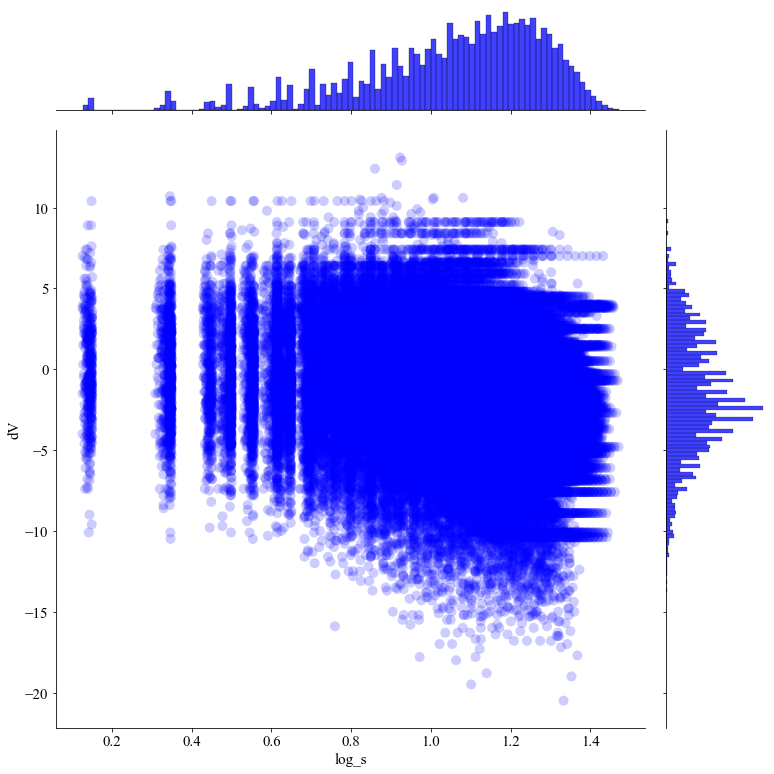

In [20]:
mask = (pairs.log_s > 0) & (pairs.log_dV2 > -4)
ax = sns.jointplot(x='log_s', y='dV', data=pairs[mask], alpha=0.2, s=100, edgecolor='none',color="blue")
ax.fig.set_size_inches(12, 12)

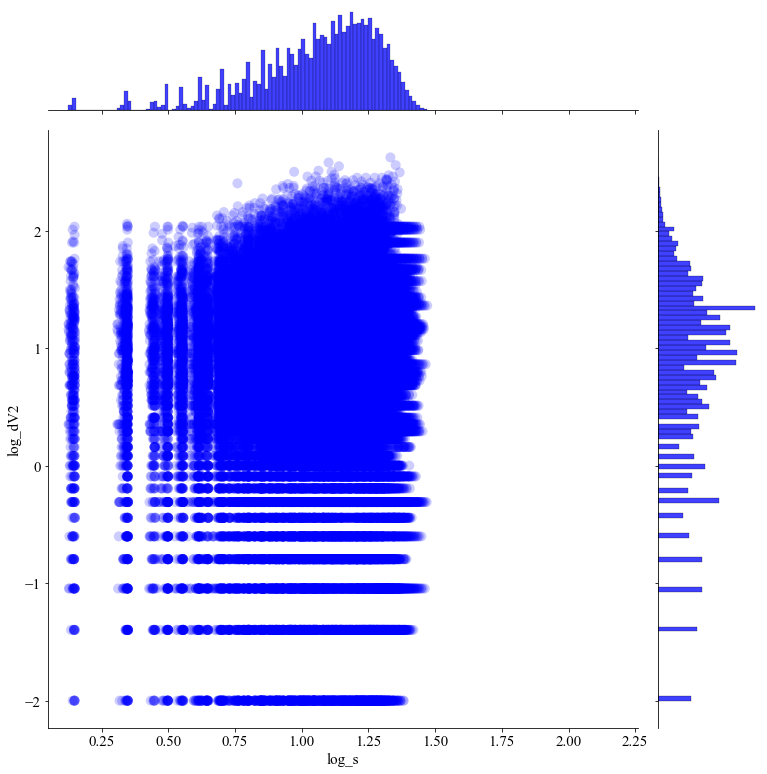

In [21]:
mask = (pairs.log_s > 0) & (pairs.log_dV2 > -4)
ax = sns.jointplot(x='log_s', y='log_dV2', data=pairs[mask], alpha=0.2, s=100, edgecolor='none', color="blue", xlim=[0.05, 2.26])
ax.fig.set_size_inches(12, 12)

In [22]:
pairs.loc[:, 's_class'] = pd.Categorical((2*pairs.log_s + 0.1).astype('int'), ordered=True)
pairs.s_class[pairs.s_class == 0] = 1

In [23]:
for j in range(5):
    print()
    print("s_class =", j)
    print(pairs[pairs.s_class == j][['dV2', 'log_s']].describe())


s_class = 0
       dV2  log_s
count  0.0    0.0
mean   NaN    NaN
std    NaN    NaN
min    NaN    NaN
25%    NaN    NaN
50%    NaN    NaN
75%    NaN    NaN
max    NaN    NaN

s_class = 1
                dV2         log_s
count  26321.000000  26321.000000
mean      11.805423      0.736789
std       19.194874      0.183688
min        0.000000      0.126037
25%        0.250000      0.642616
50%        4.410000      0.790089
75%       15.210000      0.879803
max      252.810000      0.949958

s_class = 2
                dV2         log_s
count  77034.000000  77034.000000
mean      14.125536      1.191107
std       24.988374      0.127378
min        0.000000      0.950221
25%        0.040000      1.087998
50%        4.840000      1.194835
75%       16.810000      1.292410
max      420.250000      1.449909

s_class = 3
              dV2       log_s
count  973.000000  973.000000
mean     0.402066    1.473296
std      3.774974    0.018304
min      0.000000    1.450098
25%      0.000000    1.4

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


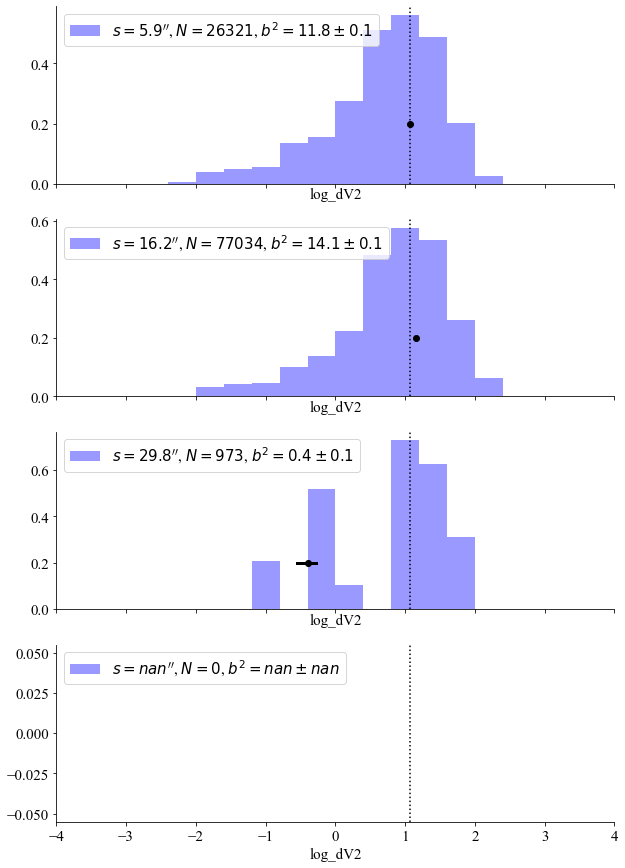

In [24]:
sig2 = pairs.dV2.mean()
sig2a = 2*np.var(df1.V)
fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
for sclass, ax in zip(range(1, 5), axes):
    b2mean = np.mean(pairs.dV2[pairs.s_class == sclass])
    b2std = np.std(pairs.dV2[pairs.s_class == sclass])
    b2mean2 = np.mean(pairs.log_dV2[pairs.s_class == sclass])
    n = np.sum(pairs.s_class == sclass)
    b2sem = b2std/np.sqrt(n)
    smean = np.mean(10**pairs.log_s[pairs.s_class == sclass])
    label = f"$s = {smean:.1f}''$"
    label += f", $N = {n}$"
    label += fr", $b^2 = {b2mean:.1f} \pm {b2sem:.1f}$"
    sns.distplot(pairs.log_dV2[pairs.s_class == sclass], 
                 norm_hist=True, kde=False, ax=ax,
                 label=label, bins=20, color="blue",hist_kws=dict(range=[-4.0, 4.0])
                )
    ax.plot([np.log10(b2mean)], [0.2], 'o', color='k')
    ax.plot([np.log10(b2mean - b2sem), np.log10(b2mean + b2sem)], [0.2]*2, lw=3, color='k')
    ax.axvline(np.log10(sig2a), color='k', ls=':')
    ax.set(xlim=[-4.0, 4.0])
    ax.legend(loc='upper left')
sns.despine()

In [25]:
print(f'Dotted line is 2 x sigma^2 = {sig2a:.2f}')

Dotted line is 2 x sigma^2 = 11.89


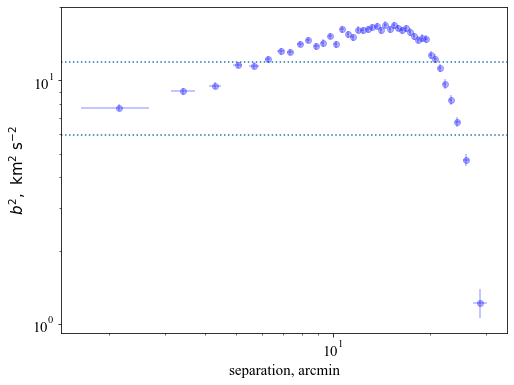

In [26]:
ngroup = 2500
groups = np.arange(len(pairs)) // ngroup
table = pairs[['s', 'dV2']].sort_values('s').groupby(groups).describe()
fig, ax = plt.subplots(figsize=(8, 6))
s = table[('s', 'mean')]
e_s = table[('s', 'std')]
b2 = table[('dV2', 'mean')]
ng = table[('dV2', 'count')]
e_b2 = table[('dV2', 'std')]/np.sqrt(ng - 1)
ax.axhline(sig2a, ls=':')
ax.axhline(0.5*sig2a, ls=':')
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.3, color="blue")
#sgrid = np.logspace(0.3, 1.65)
#ax.plot(sgrid, 38.5*sgrid**(0.8), color="k", lw=0.5)
ax.set(xscale='log', yscale='log', 
       xlabel='separation, arcmin',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

In [27]:

d_log_s = 0.2
log_s_min = np.min(pairs["log_s"])
#log_s_min = 0.01
ils = ((pairs["log_s"] - log_s_min) / d_log_s).astype(int).rename("ils")
ils[ils < 0] = 0
ils


29   0      0
30   0      1
     1      0
31   0      1
     1      1
           ..
671  638    2
     639    2
     640    1
     641    1
     642    0
Name: ils, Length: 104328, dtype: int32

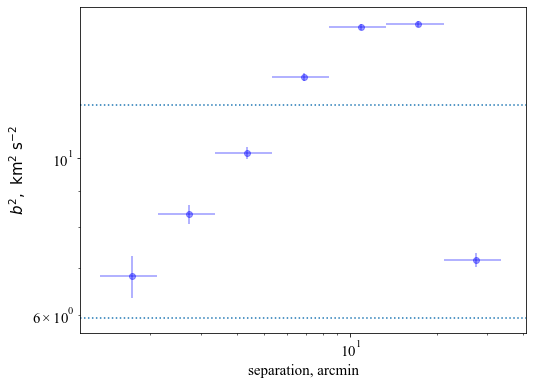

In [35]:
table = pairs[['s', 'dV2']].groupby(ils).describe()
fig, ax = plt.subplots(figsize=(8, 6))
s = 0.5 * (table[('s', 'min')] + table[('s', 'max')])
e_s = 0.5 * (table[('s', 'max')] - table[('s', 'min')])
b2 = table[('dV2', 'mean')]
ng = table[('dV2', 'count')]
e_b2 = table[('dV2', 'std')] / np.sqrt(ng)
#ax.plot(s, b2, 'o')
ax.axhline(sig2a, ls=':')
ax.axhline(0.5*sig2a, ls=':')
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.4,color="blue")
ax.set(xscale='log', yscale='log', 
       xlabel='separation, arcmin',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

In [30]:
b2

ils
0     6.810619
1     8.340333
2    10.177724
3    13.012774
4    15.351810
5    15.474844
6     7.184611
7     0.000000
Name: (dV2, mean), dtype: float64

In [31]:
pc=0.12
sc=s*pc

In [32]:
table=[sc,b2,e_s,e_b2]
dfx2=pd.DataFrame(table)
dfx2=dfx2.transpose()
dfx2=dfx2.set_axis(['pc', 'S', 'ErrX', 'ErrY'], axis=1, inplace=False)
dfx2.to_csv('SFdata//Orion2.csv',mode = 'w', index=False)

In [33]:
finish=time.time()
print("Runnig time:",finish-start, "seconds" )

Runnig time: 9.702859878540039 seconds
